<a href="https://colab.research.google.com/github/shokru/carbon_emissions/blob/main/Kaya_estimates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimating the Kaya identity

This note book shows how to compare the elements of the Kaya identity across countries.

In [2]:
import pandas as pd                      # This library is for data wrangling
import seaborn as sns                    # This is one library for plotting
import matplotlib.pyplot as plt          # Yet another library for visualization
import plotly.express as px              # This is another library for plots 
import requests
import json
from zipfile import ZipFile
from io import BytesIO
import warnings                          # This is to remove warning to keep output clean
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 6)     # First 3 and last 3 rows will be shown

First, population.

In [3]:
url = 'https://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=excel'
data_pop = pd.read_excel(url, skiprows = 3) 
data_pop
data_pop = data_pop.loc[:,['Country Name', '2020']]
data_pop = data_pop.rename(columns = {"Country Name": "Country", "2020": "Population"})
data_pop

,Country,Population
0,Aruba,106766.0
1,Africa Eastern and Southern,677243299.0
2,Afghanistan,38928341.0
...,...,...
263,South Africa,59308690.0
264,Zambia,18383956.0
265,Zimbabwe,14862927.0


Second, GDP.

In [4]:
url = 'https://api.worldbank.org/v2/en/indicator/NY.GDP.MKTP.CD?downloadformat=excel'
data_gdp = pd.read_excel(url, skiprows = 3) 
# Putting the data in long format below
data_gdp = pd.wide_to_long(data_gdp.iloc[0:,0:65], 
                stubnames = [''], 
                i = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                j = 'Year').reset_index()
data_gdp = data_gdp.rename(columns = {'Country Name': 'Country', '': 'GDP'})
data_gdp = data_gdp.query('Year == 2020')
data_gdp = data_gdp.loc[ : , ['Country', 'GDP']]
data_gdp

,Country,GDP
60,Aruba,NaN
121,Africa Eastern and Southern,8.984741e+11
182,Afghanistan,1.980707e+10
...,...,...
16103,South Africa,3.019236e+11
16164,Zambia,1.932005e+10
16225,Zimbabwe,1.676851e+10


Third , energy.



In [5]:
url = 'https://www.bp.com/content/dam/bp/business-sites/en/global/corporate/xlsx/energy-economics/statistical-review/bp-stats-review-2021-consolidated-dataset-narrow-format.xlsx'
data_energy_sources = pd.read_excel(url) # Reads the online file 
data_energy_sources                      # Shows the result
data_energy_sources = data_energy_sources[data_energy_sources['Var'].str.endswith('j')]
data_energy_sources['Scale'] = data_energy_sources['Var'].transform(lambda x: 1000 if x.endswith('ej') else 1) # Scale column  
data_energy_sources['Value'] = data_energy_sources['Value'] * data_energy_sources['Scale']                     # Adjusted value
data_energy_sources = data_energy_sources.loc[:, ['Country', 'Year', 'Region', 'Var', 'Value']]                # Keeping 5 columns
data_energy_sources['Var'] = data_energy_sources['Var'].map(lambda x: x.lstrip('+-').rstrip('_ej'))            # Remove suffix
data_energy_sources['Var'] = data_energy_sources['Var'].map(lambda x: x.lstrip('+-').rstrip('_pj'))            # Remove suffix
data_energy_sources = data_energy_sources.rename(columns = {'Value' : 'Energy'})                               # Change name of column

In [6]:
categories = ['wind',
              'solar',
              'renewables',
              'ren_power',
              'oilcons',
              'nuclear',
              'hydro',
              'gascons',
              'ethanol_cons',
              'coalcons',
              'biogeo',
              'biofuels_cons',
              'biodiesel_cons']
data_energy_small = data_energy_sources[data_energy_sources['Var'].isin(categories + ['pop'])]                 # Reduce number of variables
data_energy_small = data_energy_small.query('Year == 2020')
data_energy = data_energy_small.pivot_table(index = 'Country',
                              values = 'Energy',
                              aggfunc = sum).reset_index()
data_energy = data_energy.replace("US", "United States")
data_energy

,Country,Energy
0,Algeria,2309.387128
1,Argentina,3417.509121
2,Australia,6465.805665
...,...,...
91,Uzbekistan,1872.922562
92,Venezuela,1441.768405
93,Vietnam,4256.932955


Finally, emissions, in MtCO2.

In [7]:
url = 'https://wri-public-data.s3.amazonaws.com/resourcewatch/cli_008_greenhouse_gas_emissions_country_sector.zip'
filename = requests.get(url).content
zf = ZipFile( BytesIO(filename), 'r')
zf.getinfo('historical_emissions.zip')
zf = ZipFile(zf.open('historical_emissions.zip'))

data_ghg = pd.read_csv(zf.open('historical_emissions.csv'))
data_ghg = data_ghg.loc[:,['Country', 'Sector', '2018']].pivot_table(index = 'Country',
                                                          values = '2018',
                                                          aggfunc = sum).reset_index()
data_ghg = data_ghg.rename(columns = {'2018': 'Emissions'})
data_ghg

,Country,Emissions
0,Afghanistan,376.67
1,Albania,34.49
2,Algeria,833.95
...,...,...
192,Yemen,75.03
193,Zambia,238.24
194,Zimbabwe,284.92


Now, let's aggregate everything!

In [28]:
data = pd.merge(pd.merge(pd.merge(data_ghg, data_pop), data_gdp), data_energy)
data['Country'].unique()

array(['Algeria', 'Argentina', 'Australia', 'Austria', 'Azerbaijan',
       'Bangladesh', 'Belarus', 'Belgium', 'Brazil', 'Bulgaria', 'Canada',
       'Chile', 'China', 'Colombia', 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Ecuador', 'Estonia', 'Finland',
       'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Kazakhstan', 'Kuwait', 'Latvia', 'Lithuania', 'Luxembourg',
       'Malaysia', 'Mexico', 'Morocco', 'Netherlands', 'New Zealand',
       'Norway', 'Oman', 'Pakistan', 'Peru', 'Philippines', 'Poland',
       'Portugal', 'Qatar', 'Romania', 'Saudi Arabia', 'Singapore',
       'Slovenia', 'South Africa', 'Spain', 'Sri Lanka', 'Sweden',
       'Switzerland', 'Thailand', 'Turkey', 'Turkmenistan', 'Ukraine',
       'United Arab Emirates', 'United Kingdom', 'United States',
       'Uzbekistan', 'Vietnam'], dtype=object)

Now let's see the differences. We know roughly the orders of magnitudes of populations so we focus on the other terms.

In [29]:
country_list = ['United States', 'France', 'China', 'Germany', 'Canada', 'Bangladesh', 'Quatar', 'Morocco', 'Argentina', 'Israel']
data_plot = data[data['Country'].isin(country_list)]
data_plot['gdp_pop'] = data_plot['GDP'] / data_plot['Population']
data_plot['energy_gdp'] = data_plot['Energy'] / data_plot['GDP']
data_plot['emission_energy'] = data_plot['Emissions'] / data_plot['Energy']
data_plot = data_plot.loc[:, ['Country', 'gdp_pop', 'energy_gdp', 'emission_energy']]
data_plot = pd.melt(data_plot, id_vars = 'Country', value_vars = ['gdp_pop', 'energy_gdp', 'emission_energy']).reset_index()
data_plot



,index,Country,variable,value
0,0,Argentina,gdp_pop,8441.919439
1,1,Bangladesh,gdp_pop,1968.792225
2,2,Canada,gdp_pop,43241.617828
...,...,...,...,...
24,24,Israel,emission_energy,0.288408
25,25,Morocco,emission_energy,0.346983
26,26,United States,emission_energy,0.227230


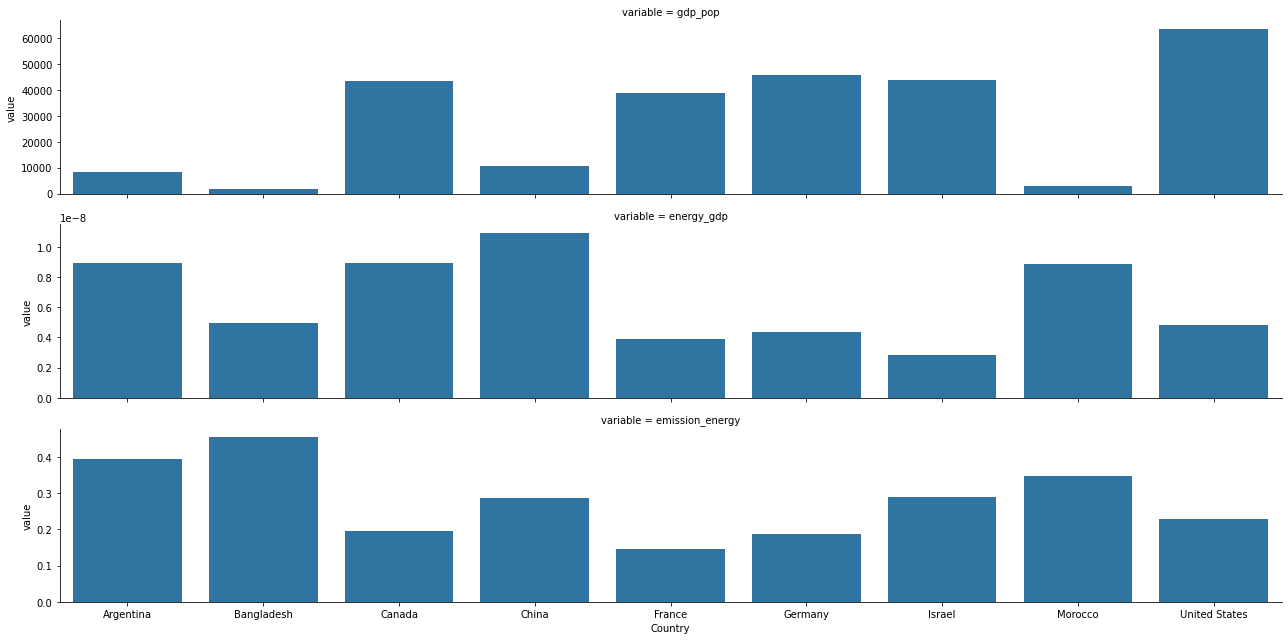

In [30]:
g = sns.FacetGrid(data_plot, row = "variable", sharey = False, aspect = 6)
g.map_dataframe(sns.barplot, x = "Country", y = "value")

Let's improve that a bit.

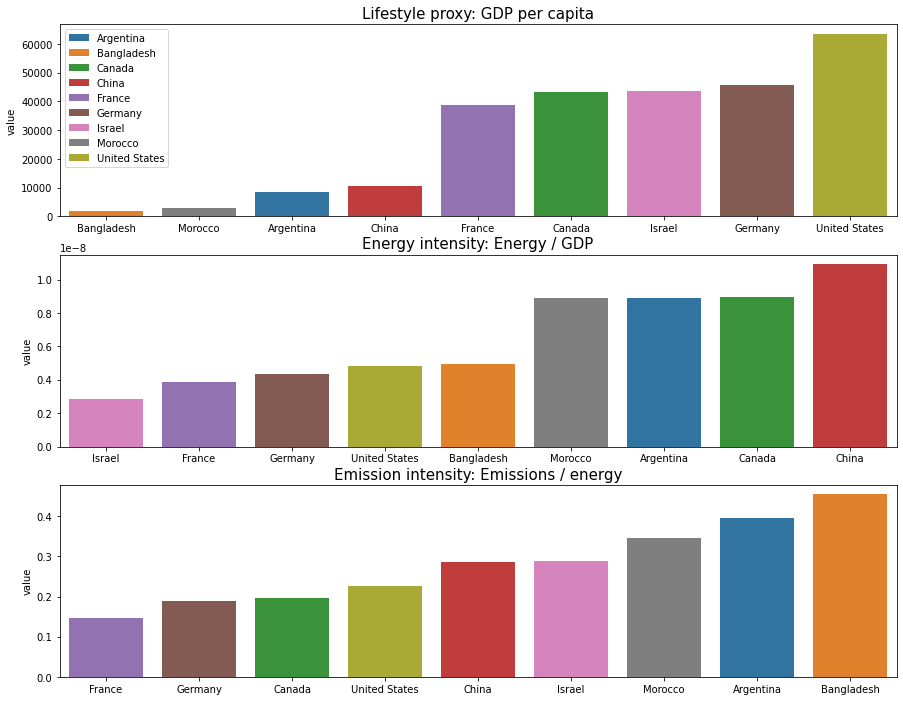

In [65]:
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
# make barplot and sort bars
sns.barplot(ax=axes[0],
            x = 'Country',
            y = "value", 
            hue = 'Country',
            dodge = False,
            data = data_plot.query('variable == "gdp_pop"'), 
            order = data_plot.query('variable == "gdp_pop"').sort_values('value').Country)
axes[0].set_title("Lifestyle proxy: GDP per capita", size = 15)
axes[0].axes.xaxis.label.set_visible(False)
axes[0].legend(loc = 'upper left')
sns.barplot(ax=axes[1],
            x = 'Country',
            y = "value", 
            hue = 'Country',
            dodge = False,
            data = data_plot.query('variable == "energy_gdp"'), 
            order = data_plot.query('variable == "energy_gdp"').sort_values('value').Country)
axes[1].set_title("Energy intensity: Energy / GDP", size = 15)
axes[1].axes.xaxis.label.set_visible(False)
axes[1].legend([],[], frameon=False)
sns.barplot(ax=axes[2],
            x = 'Country',
            y = "value", 
            hue = 'Country',
            dodge = False,
            data = data_plot.query('variable == "emission_energy"'), 
            order = data_plot.query('variable == "emission_energy"').sort_values('value').Country)
axes[2].set_title("Emission intensity: Emissions / energy", size = 15)
axes[2].axes.xaxis.label.set_visible(False)
axes[2].legend([],[], frameon=False)